In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta
import numpy as np

In [2]:
juvenile_df = pd.read_csv('../Data/juvenile_clean.csv', index_col = 0, dtype={8: str})

In [3]:
juvenile_df['CheckoutDate'] = pd.to_datetime(juvenile_df['CheckoutDate'])

## General Data Description

In [4]:
juvenile_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6443528 entries, 0 to 6443527
Data columns (total 25 columns):
 #   Column           Dtype         
---  ------           -----         
 0   UsageClass       object        
 1   CheckoutType     object        
 2   MaterialType     object        
 3   CheckoutYear     int64         
 4   CheckoutMonth    int64         
 5   Checkouts        int64         
 6   Title            object        
 7   ISBN             object        
 8   Creator          object        
 9   Subjects         object        
 10  Publisher        object        
 11  PublicationYear  object        
 12  TitleNotes       object        
 13  CreatorName      object        
 14  CopyrightList    object        
 15  CopyrightDate    float64       
 16  PCopyrightList   object        
 17  PCopyrightDate   float64       
 18  PrintingDate     float64       
 19  ApproxDate       float64       
 20  PubDate          float64       
 21  OtherDateList    object        
 22 

In [5]:
juvenile_df['UsageClass'].value_counts(dropna=False)

UsageClass
Physical    4528917
Digital     1914611
Name: count, dtype: int64

In [6]:
juvenile_df['CheckoutType'].value_counts(dropna=False)

CheckoutType
Horizon      4528917
OverDrive    1914611
Name: count, dtype: int64

In [7]:
juvenile_df['MaterialType'].value_counts(dropna=False)

MaterialType
Book                       4213582
Ebook                      1416036
Audiobook                   497245
Sounddisc                   195479
Videodisc                    80975
Regprint                     18926
Soundrec                      5799
Er, Soundrec                  4618
Soundcass                     4411
Visual                        1030
Video                          955
Videocass                      654
Er, Sounddisc                  591
Er                             477
Kit                            467
Musicsndrec                    397
Music                          375
Unspecified                    362
Sounddisc, Videodisc           249
Largeprint                     181
Regprint, Sounddisc            179
Mixed                          176
Regprint, Videorec             114
Er, Videodisc                  111
Flashcard, Sounddisc            99
Er, Sounddisc, Soundrec         40
Name: count, dtype: int64

In [8]:
phys_books = ['Book', 'Regprint', 'Largeprint', 'Regprint, Sounddisc']
ebooks = ['Ebook']
audiobooks = ['Audiobook', 'Er', 'Er, Soundrec', 'Er, Sounddisc', 'Sounddisc', 'Soundrec', 'Soundcass', 'Er, Sounddisc, Soundrec']
music = ['Musicsndrec', 'Music']
videos = ['Visual', 'Video', 'Videocass', 'Er, Videodisc', 'Videodisc']
other = ['Kit', 'Unspecified', 'Sounddisc, Videodisc', 'Mixed', 'Regprint, Videorec', 'Flashcard, Sounddisc']

In [9]:
juvenile_df['MaterialCategory'] = np.where(juvenile_df.MaterialType.isin(phys_books), 'Book',
                                             np.where(juvenile_df.MaterialType.isin(ebooks), 'E-book',
                                                      np.where(juvenile_df.MaterialType.isin(audiobooks), 'Audiobook',
                                                               np.where(juvenile_df.MaterialType.isin(music), 'Music',
                                                                        np.where(juvenile_df.MaterialType.isin(videos), 'Video',
                                                                                 np.where(juvenile_df.MaterialType.isin(other), 'Other', np.nan))))))

In [10]:
juvenile_df['MaterialCategory'].value_counts()

MaterialCategory
Book         4232868
E-book       1416036
Audiobook     708660
Video          83725
Other           1467
Music            772
Name: count, dtype: int64

In [11]:
juvenile_df['CheckoutDate'].describe()

count                          6443528
mean     2018-01-15 22:05:10.878637312
min                2005-04-01 00:00:00
25%                2014-05-01 00:00:00
50%                2018-08-01 00:00:00
75%                2022-08-01 00:00:00
max                2025-11-01 00:00:00
Name: CheckoutDate, dtype: object

## Identifying Popular Books

### Overall top books

In [33]:
top10_overall = juvenile_df.groupby(['CreatorName', 'Title'], as_index = False)['Checkouts'].sum().sort_values('Checkouts', ascending = False).head(10).rename(columns = {'Checkouts': 'TotalCheckouts'})

In [84]:
top10_overall = pd.merge(top10_overall, juvenile_df.groupby(['CreatorName', 'Title', 'UsageClass'], as_index = False)['Checkouts'].sum(), how = 'inner', on = ['CreatorName', 'Title']).pivot(index = ['CreatorName', 'Title', 'TotalCheckouts'], columns = 'UsageClass', values = 'Checkouts').reset_index().sort_values('TotalCheckouts', ascending = False).reset_index(drop = True)

In [85]:
top10_overall

UsageClass,CreatorName,Title,TotalCheckouts,Digital,Physical
0,R. J. Palacio,Wonder,14959,7393.0,7566.0
1,Mo Willems,Are You Ready To Play Outside?,12774,NaN,12774.0
2,J. K. Rowling,Harry Potter And The Sorcerer's Stone,12299,705.0,11594.0
3,Mo Willems,Pigs Make Me Sneeze!,12068,NaN,12068.0
4,Mo Willems,There Is A Bird On Your Head!,12038,NaN,12038.0
5,Mo Willems,I Love My New Toy!,11806,NaN,11806.0
6,Mo Willems,My Friend Is Sad,11684,NaN,11684.0
7,Mo Willems,I Will Surprise My Friend!,11593,NaN,11593.0
8,Mo Willems,Today I Will Fly!,11483,NaN,11483.0
9,Bill Martin,Chicka Chicka Boom Boom,11049,294.0,10755.0


In [62]:
top10_overall[['Title', 'CreatorName']]

UsageClass,Title,CreatorName
0,Wonder,R. J. Palacio
1,Are You Ready To Play Outside?,Mo Willems
2,Harry Potter And The Sorcerer's Stone,J. K. Rowling
3,Pigs Make Me Sneeze!,Mo Willems
4,There Is A Bird On Your Head!,Mo Willems
5,I Love My New Toy!,Mo Willems
6,My Friend Is Sad,Mo Willems
7,I Will Surprise My Friend!,Mo Willems
8,Today I Will Fly!,Mo Willems
9,Chicka Chicka Boom Boom,Bill Martin


Text(0, 0.5, 'Monthly Checkouts')

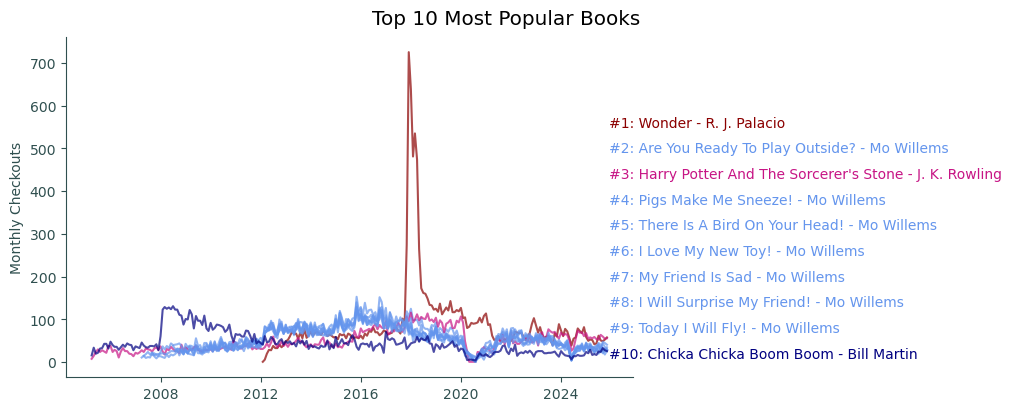

In [72]:
## Narrow down the data to graph
top10_OT = pd.merge(juvenile_df, top10_overall, how = 'inner', on = ['CreatorName', 'Title'])

## Build the graph
fig, ax = plt.subplots(figsize = (10,4), layout = 'constrained')

colors = {'J. K. Rowling': 'MediumVioletRed', 'R. J. Palacio': 'DarkRed', 'Mo Willems': 'CornflowerBlue', 'Bill Martin': 'Navy'}

for i, r in top10_overall.iterrows():
    title = r['Title']
    author = r['CreatorName']

    filtered = top10_OT.loc[top10_OT['Title'] == title].groupby(['Title', 'CreatorName', 'CheckoutDate'], as_index = False)['Checkouts'].sum()
    plt.plot(filtered['CheckoutDate'], filtered['Checkouts'], 
             color = colors.get(author), label = title, alpha = .7)

    plt.text(s = '#' + str(i+1) + ': ' + title + ' - ' + author, x = filtered['CheckoutDate'].max() + timedelta(days = 25), 
             y = 550 - (i*60) ##filtered.loc[filtered['CheckoutDate'] == filtered['CheckoutDate'].max(), 'Checkouts']
             , color = colors.get(author))


## Graph title
fig.suptitle('Top 10 Most Popular Books', size = 'x-large', color = 'black')

## axis customization:
ax.tick_params(axis = 'x', colors = 'darkslategray', labelrotation = 0)
ax.spines[['top', 'right']].set_visible(False)
ax.spines[['left', 'bottom']].set_color('darkslategray')
ax.tick_params(axis = 'y', colors = 'darkslategray', labelrotation = 0)
ax.tick_params(axis = 'x', colors = 'darkslategray')
ax.set_ylabel('Monthly Checkouts', color = 'darkslategray')

##plt.savefig('', transparent = True) 

### Top monthly checkout numbers

In [87]:
top_monthly_checkouts = juvenile_df.groupby(['CreatorName', 'Title', 'CheckoutDate'], as_index = False)['Checkouts'].sum().sort_values('Checkouts', ascending = False).rename(columns = {'Checkouts': 'MonthlyCheckouts'}).head(10)

In [93]:
top_monthly_checkouts = pd.merge(top_monthly_checkouts, juvenile_df.groupby(['CreatorName', 'Title', 'CheckoutDate', 'UsageClass'], as_index = False)['Checkouts'].sum(), how = 'inner', on = ['CreatorName', 'Title', 'CheckoutDate']).pivot(index = ['CreatorName', 'Title', 'CheckoutDate', 'MonthlyCheckouts'], columns = 'UsageClass', values = 'Checkouts').reset_index().sort_values('MonthlyCheckouts', ascending = False).reset_index(drop = True)

In [94]:
top_monthly_checkouts

UsageClass,CreatorName,Title,CheckoutDate,MonthlyCheckouts,Digital,Physical
0,J. K. Rowling,Harry Potter And The Sorcerer's Stone: Harry P...,2020-04-01,1894,1894.0,NaN
1,J. K. Rowling,Harry Potter And The Sorcerer's Stone: Harry P...,2020-05-01,1093,1093.0,NaN
2,Christina Diaz Gonzalez,Invisible: A Graphic Novel,2023-11-01,802,802.0,NaN
3,John Green,Turtles All The Way Down,2017-12-01,777,NaN,777.0
4,J. K. Rowling,Harry Potter And The Sorcerer's Stone: Harry P...,2020-04-01,743,743.0,NaN
5,J. K. Rowling,Harry Potter And The Sorcerer's Stone: Harry P...,2020-06-01,743,743.0,NaN
6,R. J. Palacio,Wonder,2017-12-01,725,63.0,662.0
7,Andrea Davis Pinkney,The Red Pencil (unabridged),2018-11-01,716,716.0,NaN
8,John Green,Turtles All The Way Down,2018-01-01,654,NaN,654.0
9,R. J. Palacio,Wonder,2018-01-01,638,76.0,562.0


### Top books each year

In [13]:
top5_per_year = pd.DataFrame()

for year in juvenile_df.CheckoutYear.unique():
    ## check number of months with data for that year, and only compare complete years
    months = juvenile_df.loc[juvenile_df['CheckoutYear'] == year, 'CheckoutMonth'].unique()
    if len(months) == 12:
        df = juvenile_df.loc[juvenile_df['CheckoutYear'] == year].groupby(['CheckoutYear', 'CreatorName', 'Title'], as_index = False)['Checkouts'].sum().sort_values('Checkouts', ascending = False).head(5)
        df['Rank'] = [1, 2, 3, 4, 5]
        top5_per_year = pd.concat([top5_per_year, df])

In [14]:
top5_per_year.CheckoutYear.unique()

array([2023, 2024, 2016, 2020, 2017, 2022, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2018, 2013, 2014, 2015, 2019, 2021], dtype=int64)

In [15]:
top5_per_year

,CheckoutYear,CreatorName,Title,Checkouts,Rank
11634,2023,Christina Diaz Gonzalez,Invisible: A Graphic Novel,1482,1
28713,2023,J.R.R. Tolkien,The Hobbit (unabridged),1409,2
46902,2023,Madeleine L'Engle,A Wrinkle In Time (unabridged),1403,3
28450,2023,J. K. Rowling,Harry Potter And The Chamber Of Secrets (unabr...,1306,4
32044,2023,Jeff Kinney,The Deep End,1121,5
...,...,...,...,...,...
25415,2021,J. K. Rowling,Harry Potter And The Chamber Of Secrets: Harry...,1770,1
13670,2021,Dav Pilkey,"Grime And Punishment: Dog Man Series, Book 9",1263,2
25435,2021,J. K. Rowling,Harry Potter And The Prisoner Of Azkaban: Harr...,1248,3
3386,2021,Ann M. Martin,Logan Likes Mary Anne!: Baby-sitters Club Grap...,1163,4


In [18]:
top5_per_year.loc[top5_per_year['CheckoutYear'] == 2006]

,CheckoutYear,CreatorName,Title,Checkouts,Rank
1047,2006,Bobby Lynn Maslen,Bob Books First!,1547,1
1048,2006,Bobby Lynn Maslen,Bob Books Fun!,1419,2
3769,2006,J. K. Rowling,Harry Potter And The Half-blood Prince,1143,3
1051,2006,Bobby Lynn Maslen,Bob Books. Pals!,664,4
3419,2006,H. A. Rey,Curious George,628,5


In [19]:
top5_per_year.loc[top5_per_year['CheckoutYear'] == 2007]

,CheckoutYear,CreatorName,Title,Checkouts,Rank
1254,2007,Bobby Lynn Maslen,Bob Books Fun!,1463,1
4501,2007,J. K. Rowling,Harry Potter And The Deathly Hallows,1406,2
1253,2007,Bobby Lynn Maslen,Bob Books First!,1330,3
4505,2007,J. K. Rowling,Harry Potter And The Half-blood Prince,972,4
1257,2007,Bobby Lynn Maslen,Bob Books. Pals!,706,5


In [21]:
top5_per_year.loc[top5_per_year['CheckoutYear'] == 2008]

,CheckoutYear,CreatorName,Title,Checkouts,Rank
1429,2008,Bill Martin,Chicka Chicka Boom Boom,1375,1
1488,2008,Bob McLeod,Superhero Abc,1355,2
1502,2008,Bobby Lynn Maslen,Bob Books Fun!,1352,3
3449,2008,Doreen Cronin,"Giggle, Giggle, Quack",1341,4
1501,2008,Bobby Lynn Maslen,Bob Books First!,1229,5


In [22]:
top5_per_year.loc[top5_per_year['CheckoutYear'] == 2009]

,CheckoutYear,CreatorName,Title,Checkouts,Rank
14918,2009,Stephenie Meyer,Twilight,1957,1
14915,2009,Stephenie Meyer,New Moon,1810,2
4038,2009,Doreen Cronin,"Giggle, Giggle, Quack",1330,3
6907,2009,Jane Yolen,How Do Dinosaurs Say Good Night?,1211,4
14912,2009,Stephenie Meyer,Eclipse,1192,5


In [23]:
top5_per_year.loc[top5_per_year['CheckoutYear'] == 2010]

,CheckoutYear,CreatorName,Title,Checkouts,Rank
17800,2010,Suzanne Collins,The Hunger Games,1114,1
4752,2010,Doreen Cronin,"Giggle, Giggle, Quack",1021,2
2094,2010,Bobby Lynn Maslen,Bob Books Fun!,1019,3
11510,2010,Linnea Asplind Riley,Mouse Mess,1010,4
8054,2010,Jane Yolen,How Do Dinosaurs Say Good Night?,985,5


In [24]:
top5_per_year.loc[top5_per_year['CheckoutYear'] == 2011]

,CheckoutYear,CreatorName,Title,Checkouts,Rank
22499,2011,Suzanne Collins,The Hunger Games,1645,1
22496,2011,Suzanne Collins,Mockingjay,1579,2
16165,2011,Markus Zusak,The Book Thief,961,3
1554,2011,Arnold Lobel,Days With Frog And Toad,900,4
1557,2011,Arnold Lobel,Frog And Toad All Year,888,5


In [25]:
top5_per_year.loc[top5_per_year['CheckoutYear'] == 2012]

,CheckoutYear,CreatorName,Title,Checkouts,Rank
27231,2012,Suzanne Collins,The Hunger Games,2746,1
27221,2012,Suzanne Collins,Catching Fire,1877,2
27227,2012,Suzanne Collins,Mockingjay,1737,3
24415,2012,Rick Riordan,The Son Of Neptune,1048,4
13925,2012,John Green,The Fault In Our Stars,982,5


In [26]:
top5_per_year.loc[top5_per_year['CheckoutYear'] == 2013]

,CheckoutYear,CreatorName,Title,Checkouts,Rank
16606,2013,John Green,The Fault In Our Stars,1159,1
32366,2013,Suzanne Collins,Catching Fire,1040,2
28931,2013,Rick Riordan,The Mark Of Athena,1031,3
25314,2013,Mo Willems,Are You Ready To Play Outside?,1013,4
25347,2013,Mo Willems,Pigs Make Me Sneeze!,975,5


In [27]:
top5_per_year.loc[top5_per_year['CheckoutYear'] == 2014]

,CheckoutYear,CreatorName,Title,Checkouts,Rank
39003,2014,Veronica Roth,Allegiant,1463,1
18941,2014,John Green,The Fault In Our Stars,1448,2
26587,2014,Markus Zusak,The Book Thief,1059,3
28905,2014,Mo Willems,Pigs Make Me Sneeze!,990,4
32916,2014,Rick Riordan,The House Of Hades,982,5


In [28]:
top5_per_year.loc[top5_per_year['CheckoutYear'] == 2015]

,CheckoutYear,CreatorName,Title,Checkouts,Rank
32757,2015,Mo Willems,Pigs Make Me Sneeze!,1227,1
32753,2015,Mo Willems,My Friend Is Sad,1203,2
32740,2015,Mo Willems,I Broke My Trunk!,1147,3
32738,2015,Mo Willems,I Am Going!,1141,4
32743,2015,Mo Willems,I Will Surprise My Friend!,1126,5


In [29]:
top5_per_year.loc[top5_per_year['CheckoutYear'] == 2016]

,CheckoutYear,CreatorName,Title,Checkouts,Rank
37350,2016,Mo Willems,Pigs Make Me Sneeze!,1468,1
37307,2016,Mo Willems,Are You Ready To Play Outside?,1292,2
37362,2016,Mo Willems,There Is A Bird On Your Head!,1250,3
37331,2016,Mo Willems,I Love My New Toy!,1243,4
37330,2016,Mo Willems,I Broke My Trunk!,1231,5
